🎬 IMDb SENTIMENT ANALYSIS PIPELINE
🔹 Dataset Shape: (50000, 2)
🔹 Columns: ['review', 'sentiment']

🔹 Sample Data:
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive

🔹 Null Values:
review       0
sentiment    0
dtype: int64

🔹 Sentiment Distribution:
sentiment
positive    25000
negative    25000
Name: count, dtype: int64


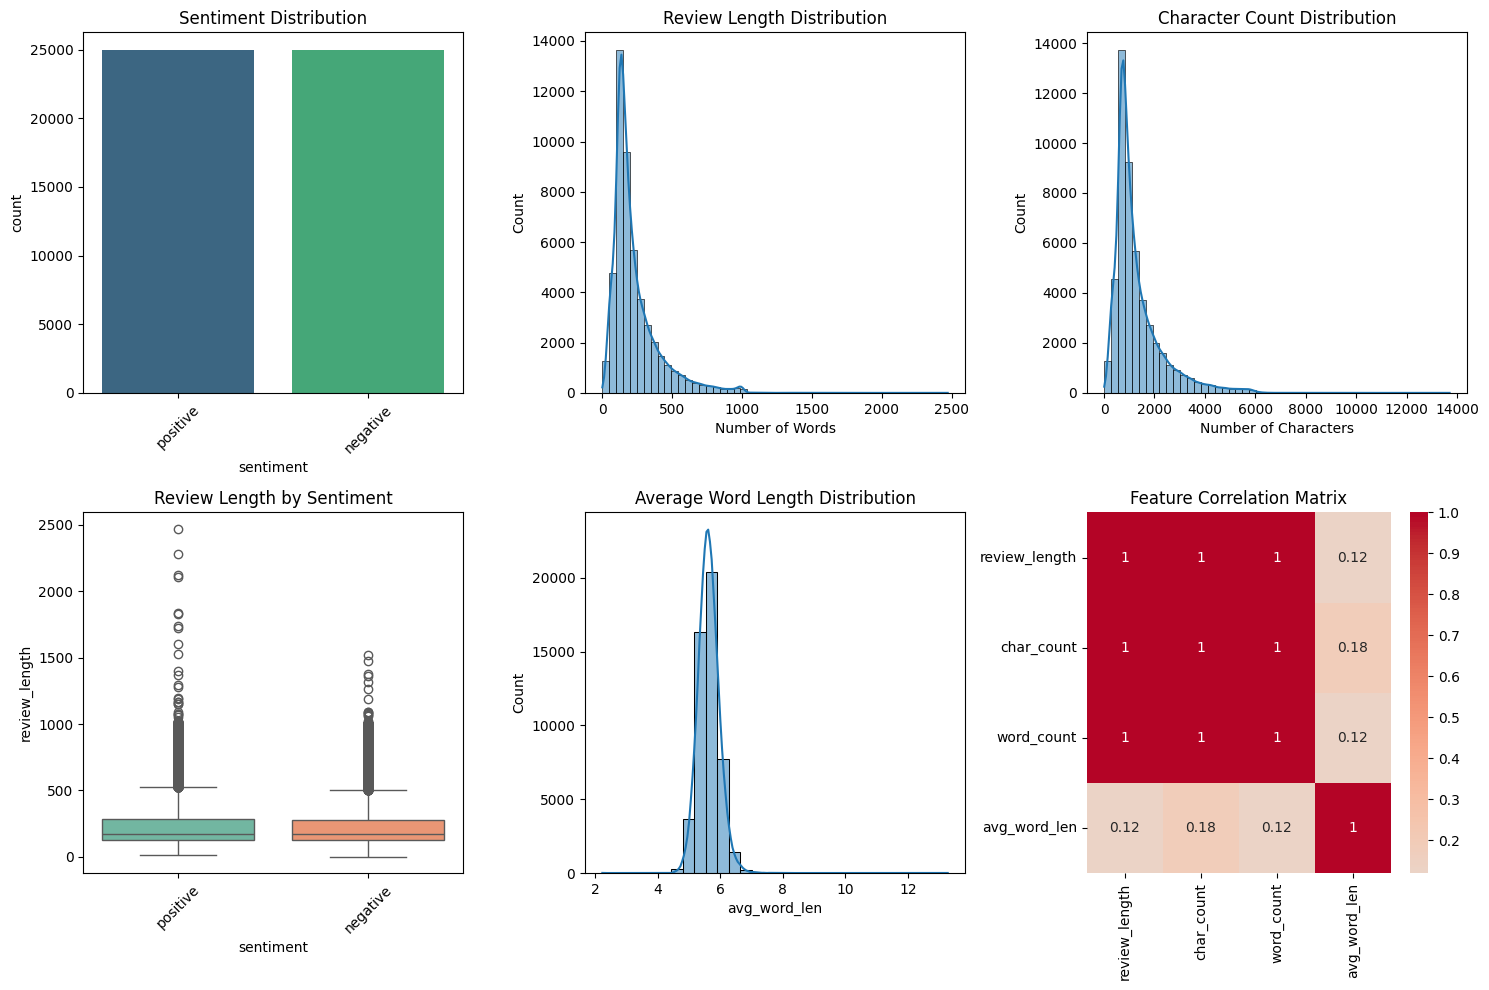


🔧 FEATURE ENGINEERING
----------------------------------------
📝 Preprocessing text...

🔹 Sample Cleaned Reviews:

Original: One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. The...
Cleaned:  one reviewer mentioned watching episode hooked right exactly happened first thing struck brutality u...

Original: A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-B...
Cleaned:  wonderful little production filming technique unassuming old time bbc fashion give comforting someti...

📊 Creating TF-IDF features...
✅ Final feature matrix shape: (50000, 5003)

🤖 MODEL TRAINING & EVALUATION
----------------------------------------

🔄 Training Logistic Regression...
✅ Logistic Regression:
   Accuracy: 0.8935
   ROC-AUC: 0.95985808
   CV Score: 0.8877 (±0.0041)

🔄 Training Naive Bayes...
✅ Naive Bayes:
   Accuracy: 0.8629
   ROC-AUC: 0.9357229200000001
   CV Score: 0.8588 (±0.0035)

🔄 Training Random Forest.

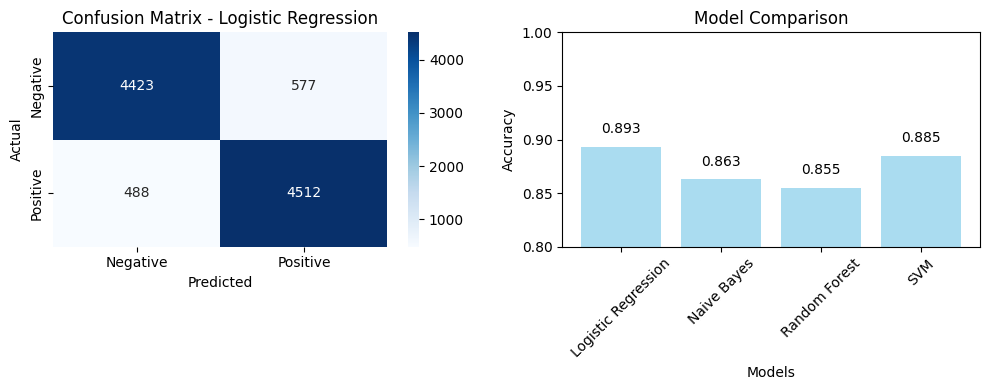


☁️ GENERATING WORD CLOUDS
----------------------------------------


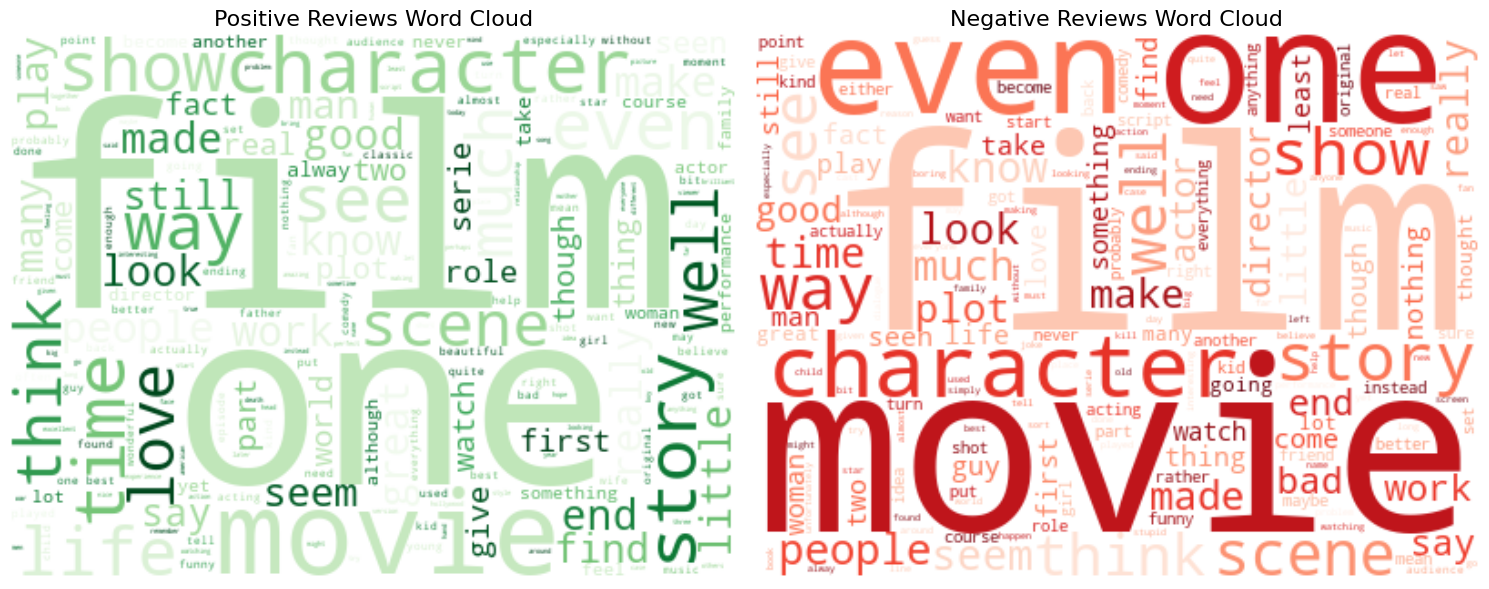


🎯 SENTIMENT PREDICTION DEMO
----------------------------------------
Review: 'This movie was absolutely fantastic! Great acting and storyline.'
Predicted Sentiment: Positive (Confidence: 0.935)

Review: 'Terrible movie, waste of time. Poor acting and boring plot.'
Predicted Sentiment: Negative (Confidence: 1.000)

Review: 'It was okay, nothing special but not bad either.'
Predicted Sentiment: Negative (Confidence: 0.998)

✅ Analysis Complete!
✅ Models successfully trained and ready for use!


In [1]:
# Enhanced IMDb Sentiment Analysis Pipeline - FIXED
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.sparse import hstack
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

# Download required NLTK data
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

def load_and_explore_data(file_path=r"C:\Users\lenovo\Downloads\Imdb - data_imdb.csv"):
    """Load and perform initial exploration of the dataset"""
    print("=" * 60)
    print("🎬 IMDb SENTIMENT ANALYSIS PIPELINE")
    print("=" * 60)
    
    # Load dataset
    df = pd.read_csv(file_path)
    
    # Basic exploration
    print(f"🔹 Dataset Shape: {df.shape}")
    print(f"🔹 Columns: {list(df.columns)}")
    print("\n🔹 Sample Data:")
    print(df.head())
    
    # Check for null values
    print(f"\n🔹 Null Values:\n{df.isnull().sum()}")
    
    # Class distribution
    print(f"\n🔹 Sentiment Distribution:\n{df['sentiment'].value_counts()}")
    
    return df

def visualize_data(df):
    """Create visualizations for data exploration"""
    plt.figure(figsize=(15, 10))
    
    # Sentiment distribution
    plt.subplot(2, 3, 1)
    sns.countplot(data=df, x='sentiment', palette='viridis')
    plt.title("Sentiment Distribution")
    plt.xticks(rotation=45)
    
    # Review length analysis
    df['review_length'] = df['review'].apply(lambda x: len(str(x).split()))
    
    plt.subplot(2, 3, 2)
    sns.histplot(df['review_length'], bins=50, kde=True)
    plt.title("Review Length Distribution")
    plt.xlabel("Number of Words")
    
    # Character count distribution
    df['char_count'] = df['review'].apply(lambda x: len(str(x)))
    
    plt.subplot(2, 3, 3)
    sns.histplot(df['char_count'], bins=50, kde=True)
    plt.title("Character Count Distribution")
    plt.xlabel("Number of Characters")
    
    # Box plot: Review length by sentiment
    plt.subplot(2, 3, 4)
    sns.boxplot(data=df, x='sentiment', y='review_length', palette='Set2')
    plt.title("Review Length by Sentiment")
    plt.xticks(rotation=45)
    
    # Average word length
    df['word_count'] = df['review'].apply(lambda x: len(str(x).split()))
    df['avg_word_len'] = df['char_count'] / df['word_count']
    
    plt.subplot(2, 3, 5)
    sns.histplot(df['avg_word_len'], bins=30, kde=True)
    plt.title("Average Word Length Distribution")
    
    # Correlation heatmap of numerical features
    plt.subplot(2, 3, 6)
    numeric_features = ['review_length', 'char_count', 'word_count', 'avg_word_len']
    corr_matrix = df[numeric_features].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title("Feature Correlation Matrix")
    
    plt.tight_layout()
    plt.show()
    
    return df

def preprocess_text(text):
    """Advanced text preprocessing function"""
    text = str(text).lower()
    
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove punctuation and numbers, keep only letters
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Tokenize
    tokens = nltk.word_tokenize(text)
    
    # Remove stopwords and lemmatize
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    
    tokens = [
        lemmatizer.lemmatize(word) 
        for word in tokens 
        if word not in stop_words and len(word) > 2
    ]
    
    return ' '.join(tokens)

def feature_engineering(df):
    """Create features for machine learning"""
    print("\n🔧 FEATURE ENGINEERING")
    print("-" * 40)
    
    # Text preprocessing
    print("📝 Preprocessing text...")
    df['cleaned_review'] = df['review'].apply(preprocess_text)
    
    # Display sample of cleaned text
    print("\n🔹 Sample Cleaned Reviews:")
    for i in range(2):
        print(f"\nOriginal: {df['review'].iloc[i][:100]}...")
        print(f"Cleaned:  {df['cleaned_review'].iloc[i][:100]}...")
    
    # TF-IDF Vectorization
    print("\n📊 Creating TF-IDF features...")
    tfidf = TfidfVectorizer(
        max_features=5000,
        ngram_range=(1, 2),  # Include bigrams
        min_df=2,  # Ignore terms that appear in less than 2 documents
        max_df=0.95  # Ignore terms that appear in more than 95% of documents
    )
    X_tfidf = tfidf.fit_transform(df['cleaned_review'])
    
    # Additional numerical features
    additional_features = df[['char_count', 'word_count', 'avg_word_len']].values
    
    # Use MinMaxScaler instead of StandardScaler to avoid negative values for NB
    scaler = MinMaxScaler()
    additional_features_scaled = scaler.fit_transform(additional_features)
    
    # Combine features
    X_final = hstack([X_tfidf, additional_features_scaled])
    
    # Target variable
    y = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)
    
    print(f"✅ Final feature matrix shape: {X_final.shape}")
    
    return X_final, y, tfidf, scaler

def train_and_evaluate_models(X, y):
    """Train multiple models and compare performance"""
    print("\n🤖 MODEL TRAINING & EVALUATION")
    print("-" * 40)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Define models
    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
        "Naive Bayes": MultinomialNB(alpha=0.1),  # Added alpha parameter for smoothing
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
        "SVM": LinearSVC(random_state=42, max_iter=1000)
    }
    
    results = {}
    
    # Train and evaluate each model
    for name, model in models.items():
        print(f"\n🔄 Training {name}...")
        
        try:
            # Fit model
            model.fit(X_train, y_train)
            
            # Predictions
            y_pred = model.predict(X_test)
            
            # Calculate metrics
            accuracy = accuracy_score(y_test, y_pred)
            
            # For ROC-AUC, we need probability predictions
            if hasattr(model, "predict_proba"):
                y_proba = model.predict_proba(X_test)[:, 1]
                roc_auc = roc_auc_score(y_test, y_proba)
            elif hasattr(model, "decision_function"):
                y_scores = model.decision_function(X_test)
                roc_auc = roc_auc_score(y_test, y_scores)
            else:
                roc_auc = "N/A"
            
            # Cross-validation score
            cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
            cv_mean = cv_scores.mean()
            cv_std = cv_scores.std()
            
            results[name] = {
                'model': model,
                'accuracy': accuracy,
                'roc_auc': roc_auc,
                'cv_mean': cv_mean,
                'cv_std': cv_std,
                'predictions': y_pred
            }
            
            print(f"✅ {name}:")
            print(f"   Accuracy: {accuracy:.4f}")
            print(f"   ROC-AUC: {roc_auc if roc_auc != 'N/A' else 'N/A'}")
            print(f"   CV Score: {cv_mean:.4f} (±{cv_std:.4f})")
            
        except Exception as e:
            print(f"❌ Error training {name}: {str(e)}")
            continue
    
    return results, X_test, y_test

def detailed_evaluation(results, X_test, y_test):
    """Provide detailed evaluation of the best model"""
    print("\n📊 DETAILED MODEL EVALUATION")
    print("-" * 40)
    
    if not results:
        print("❌ No models were successfully trained.")
        return None
    
    # Find best model based on accuracy
    best_model_name = max(results.keys(), key=lambda k: results[k]['accuracy'])
    best_model = results[best_model_name]['model']
    best_predictions = results[best_model_name]['predictions']
    
    print(f"🏆 Best Model: {best_model_name}")
    print(f"📈 Accuracy: {results[best_model_name]['accuracy']:.4f}")
    
    # Classification report
    print(f"\n📋 Classification Report:")
    print(classification_report(y_test, best_predictions))
    
    # Confusion matrix visualization
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 2, 1)
    cm = confusion_matrix(y_test, best_predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.title(f'Confusion Matrix - {best_model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    
    # Model comparison
    plt.subplot(1, 2, 2)
    model_names = list(results.keys())
    accuracies = [results[name]['accuracy'] for name in model_names]
    
    bars = plt.bar(range(len(model_names)), accuracies, color='skyblue', alpha=0.7)
    plt.xlabel('Models')
    plt.ylabel('Accuracy')
    plt.title('Model Comparison')
    plt.xticks(range(len(model_names)), model_names, rotation=45)
    plt.ylim(0.8, 1.0)
    
    # Add value labels on bars
    for bar, acc in zip(bars, accuracies):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{acc:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    return best_model

def create_wordclouds(df):
    """Create word clouds for positive and negative reviews"""
    print("\n☁️ GENERATING WORD CLOUDS")
    print("-" * 40)
    
    # Separate positive and negative reviews
    positive_text = ' '.join(df[df['sentiment'] == 'positive']['cleaned_review'])
    negative_text = ' '.join(df[df['sentiment'] == 'negative']['cleaned_review'])
    
    plt.figure(figsize=(15, 6))
    
    # Positive word cloud
    plt.subplot(1, 2, 1)
    positive_wc = WordCloud(width=400, height=300, background_color='white',
                           colormap='Greens').generate(positive_text)
    plt.imshow(positive_wc, interpolation='bilinear')
    plt.title('Positive Reviews Word Cloud', fontsize=16)
    plt.axis('off')
    
    # Negative word cloud
    plt.subplot(1, 2, 2)
    negative_wc = WordCloud(width=400, height=300, background_color='white',
                           colormap='Reds').generate(negative_text)
    plt.imshow(negative_wc, interpolation='bilinear')
    plt.title('Negative Reviews Word Cloud', fontsize=16)
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

def predict_sentiment(text, model, tfidf, scaler):
    """Predict sentiment for new text"""
    # Preprocess the text
    cleaned_text = preprocess_text(text)
    
    # Transform with TF-IDF
    text_tfidf = tfidf.transform([cleaned_text])
    
    # Create additional features (using dummy values for demonstration)
    char_count = len(text)
    word_count = len(text.split())
    avg_word_len = char_count / word_count if word_count > 0 else 0
    
    additional_features = scaler.transform([[char_count, word_count, avg_word_len]])
    
    # Combine features
    final_features = hstack([text_tfidf, additional_features])
    
    # Predict
    prediction = model.predict(final_features)[0]
    
    if hasattr(model, 'predict_proba'):
        confidence = model.predict_proba(final_features)[0].max()
        return 'Positive' if prediction == 1 else 'Negative', confidence
    else:
        return 'Positive' if prediction == 1 else 'Negative', None

def main():
    """Main execution function"""
    try:
        # Step 1: Load and explore data
        df = load_and_explore_data()
        
        # Step 2: Visualize data
        df = visualize_data(df)
        
        # Step 3: Feature engineering
        X, y, tfidf, scaler = feature_engineering(df)
        
        # Step 4: Train and evaluate models
        results, X_test, y_test = train_and_evaluate_models(X, y)
        
        # Step 5: Detailed evaluation
        best_model = detailed_evaluation(results, X_test, y_test)
        
        if best_model is None:
            return None, None, None
        
        # Step 6: Create word clouds
        create_wordclouds(df)
        
        # Step 7: Demo prediction
        print("\n🎯 SENTIMENT PREDICTION DEMO")
        print("-" * 40)
        
        sample_reviews = [
            "This movie was absolutely fantastic! Great acting and storyline.",
            "Terrible movie, waste of time. Poor acting and boring plot.",
            "It was okay, nothing special but not bad either."
        ]
        
        for review in sample_reviews:
            sentiment, confidence = predict_sentiment(review, best_model, tfidf, scaler)
            conf_str = f" (Confidence: {confidence:.3f})" if confidence else ""
            print(f"Review: '{review}'")
            print(f"Predicted Sentiment: {sentiment}{conf_str}\n")
        
        print("✅ Analysis Complete!")
        
        return best_model, tfidf, scaler
        
    except FileNotFoundError:
        print("❌ Error: CSV file not found. Please ensure the file exists in the specified path.")
        return None, None, None
    except Exception as e:
        print(f"❌ Error occurred: {str(e)}")
        return None, None, None

# Run the analysis
if __name__ == "__main__":
    model, vectorizer, feature_scaler = main()
    
    if model is None:
        print("❌ Analysis failed. Please check the error messages above.")
    else:
        print("✅ Models successfully trained and ready for use!")